In [1]:
import h5py
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sn
import torch
import torchvision.models as models
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from IPython.core.display import display
from collections.abc import Mapping
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchvision.transforms import ToTensor
import astropy.units as u
import astropy.coordinates as coord

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
from scipy import stats
import matplotlib as mpl

/tmp/ipykernel_65928/2340178517.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
score_path = '/ocean/projects/phy210068p/hsu1/Training_results/DR3_lsr012/Gaia/6D/training_score.hdf5'
with h5py.File(score_path, 'r') as f:
    print(f.keys)
    x_final = f['x_final'][:]
    score = f['score'][:]
    target = f['target'][:]

<bound method MappingHDF5.keys of <HDF5 file "training_score.hdf5" (mode r)>>


In [3]:
x_final.shape

(859343, 6)

In [4]:
ra = x_final[:,0]
dec = x_final[:,1]
pmra = x_final[:,2]
pmdec = x_final[:,3]
parallax = x_final[:,4]
rv = x_final[:,5]

mask0 = (score < 0.875)
mask1 = (score > 0.875)

ra0 = ra[mask0] * u.deg
dec0 = dec[mask0] * u.deg
pmra0 = pmra[mask0] * u.mas / u.yr
pmdec0 = pmdec[mask0] * u.mas / u.yr
parallax0 = parallax[mask0] * u.mas
rv0 = rv[mask0] * u.km / u.s

ra1 = ra[mask1] * u.deg
dec1 = dec[mask1] * u.deg
pmra1 = pmra[mask1] * u.mas / u.yr
pmdec1 = pmdec[mask1] * u.mas / u.yr
parallax1 = parallax[mask1] * u.mas
rv1 = rv[mask1] * u.km / u.s

dist0 = coord.Distance(parallax=parallax0, allow_negative=True)
icrs = coord.ICRS(
    ra=ra0, dec=dec0, distance=dist0, pm_ra_cosdec=pmra0, pm_dec=pmdec0, radial_velocity=rv0)
gal0 = icrs.transform_to(coord.Galactocentric())

x0 = gal0.x.to_value(u.kpc)
y0 = gal0.y.to_value(u.kpc)
z0 = gal0.z.to_value(u.kpc)
vx0 = gal0.v_x.to_value(u.km/u.s)
vy0 = gal0.v_y.to_value(u.km/u.s)
vz0 = gal0.v_z.to_value(u.km/u.s)  

dist1 = coord.Distance(parallax=parallax1, allow_negative=True)
icrs = coord.ICRS(
    ra=ra1, dec=dec1, distance=dist1, pm_ra_cosdec=pmra1, pm_dec=pmdec1, radial_velocity=rv1)
gal1 = icrs.transform_to(coord.Galactocentric())
x1 = gal1.x.to_value(u.kpc)
y1 = gal1.y.to_value(u.kpc)
z1 = gal1.z.to_value(u.kpc)
vx1 = gal1.v_x.to_value(u.km/u.s)
vy1 = gal1.v_y.to_value(u.km/u.s)
vz1 = gal1.v_z.to_value(u.km/u.s)  

vr0 = np.sqrt(vx0**2 + vz0**2)
vr1 = np.sqrt(vx1**2 + vz1**2)

In [6]:
len(x1), np.sum(np.isnan(x1)), len(x0) - np.sum(np.isnan(x0))
x1, x0

(array([nan, nan, nan, ..., nan, nan, nan]),
 array([        nan, -8.44818356,         nan, ..., -8.13713886,
                nan,         nan]))

ValueError: autodetected range of [nan, nan] is not finite

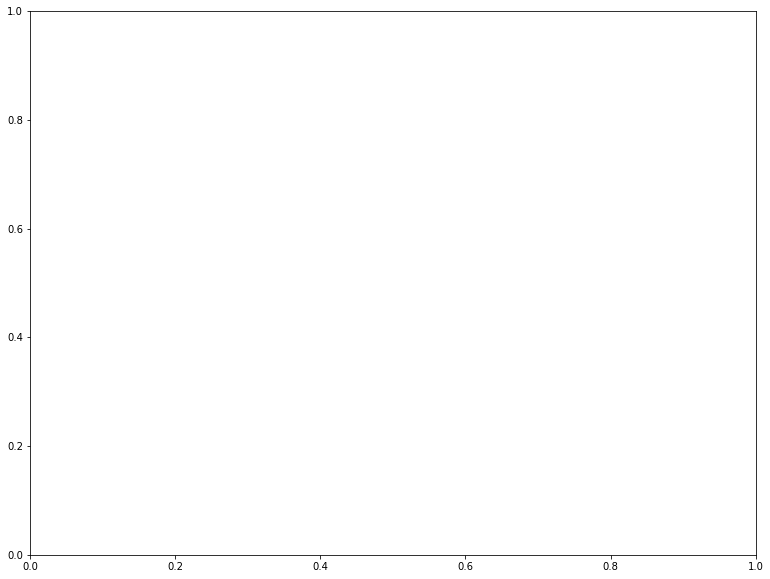

In [6]:
fig, ax = plt.subplots(1, figsize=(13, 10))

h = ax.hist2d(vy0, vr0, bins=100, weights=np.repeat(1/len(vx0), len(vx0)), norm=mpl.colors.LogNorm())
ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=35)
ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=35)
ax.set_title('Toomre Diagram of In Situ Stars', fontsize=40)
cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=35)
ax.tick_params(axis='both', labelsize=35)

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 10))

h = ax.hist2d(vy1, vr1, bins=100, weights=np.repeat(1/len(vx1), len(vx1)), norm=mpl.colors.LogNorm())
ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=35)
ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=35)
ax.set_title('Toomre Diagram of Accreted Stars', fontsize=40)
cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=35)
ax.tick_params(axis='both', labelsize=35)